# Stable Diffusion Batch Prediction with Ray Data

In [1]:
model_id = "stabilityai/stable-diffusion-2-1"
prompt = "a photo of an astronaut riding a horse on mars"

In [2]:
import ray

2023-02-27 14:03:24.711107: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/ray/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [ ]:
ray.init(
    runtime_env={
        "pip": [
            "accelerate",
            "diffusers",
            "xformers",
        ]
    }
)

In [4]:
import ray.data
import pandas as pd

ds = ray.data.from_pandas(pd.DataFrame([prompt]*4, columns=["prompt"]))

We specify an Actor to be used in `map_batches`, so that we only need to initialize the model once, instead of having to do so on each function call.

In [5]:

class PredictActor:
    def __init__(self, model_id: str, revision: str = None):
        from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
        from xformers.ops import MemoryEfficientAttentionFlashAttentionOp
        import torch

        self.pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
        self.pipe.scheduler = DPMSolverMultistepScheduler.from_config(self.pipe.scheduler.config)
        self.pipe.enable_xformers_memory_efficient_attention(attention_op=MemoryEfficientAttentionFlashAttentionOp)
        # Workaround for not accepting attention shape using VAE for Flash Attention
        self.pipe.vae.enable_xformers_memory_efficient_attention(attention_op=None)
        self.pipe = self.pipe.to("cuda")

    def __call__(self, batch: pd.DataFrame) -> pd.DataFrame:
        import torch

        # Set a different seed for every image in batch
        self.pipe.generator = [torch.Generator(device="cuda").manual_seed(i) for i in range(len(batch))]
        return self.pipe(list(batch["prompt"])).images

In [6]:
ret = ds.map_batches(
    PredictActor,
    batch_size=1,
    fn_constructor_kwargs=dict(model_id=model_id),
    compute="actors",
    num_gpus=1
)
images = ret.take_all()

2023-02-27 14:03:46,225	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[MapBatches(PredictActor)]
MapBatches(PredictActor):   0%|          | 0/1 [00:00<?, ?it/s](_MapWorker pid=34734) 2023-02-27 14:03:49.182128: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(_MapWorker pid=34734) /home/ray/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
(_MapWorker pid=34734)   from pandas import MultiIndex, Int64Index
(_MapWorker pid=34734) A matching Triton is not available, some optimizations will not be enabled.
(_MapWorker pid=34734) Error caught was: module 'triton.language' has

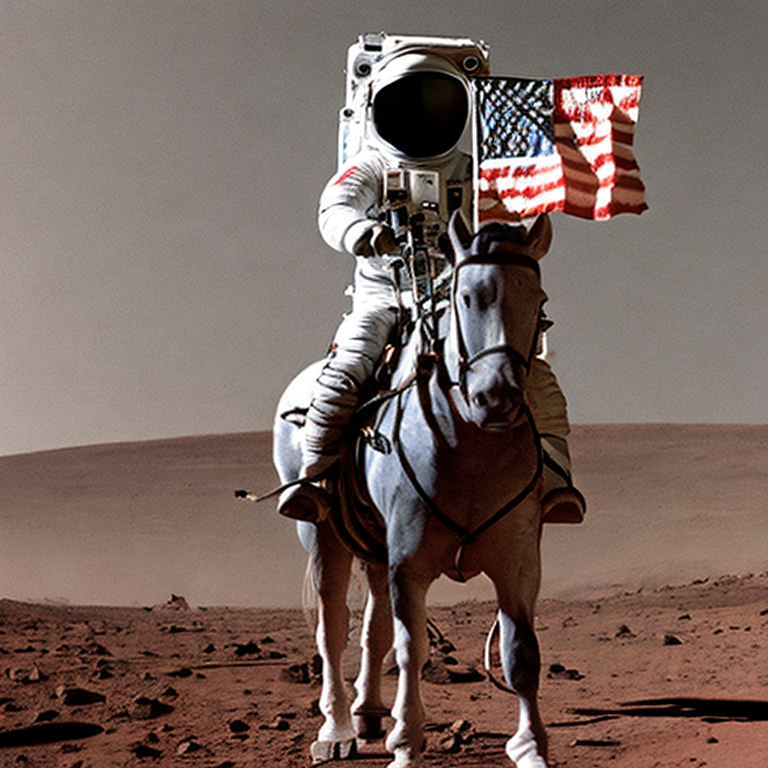

In [7]:
images[0]

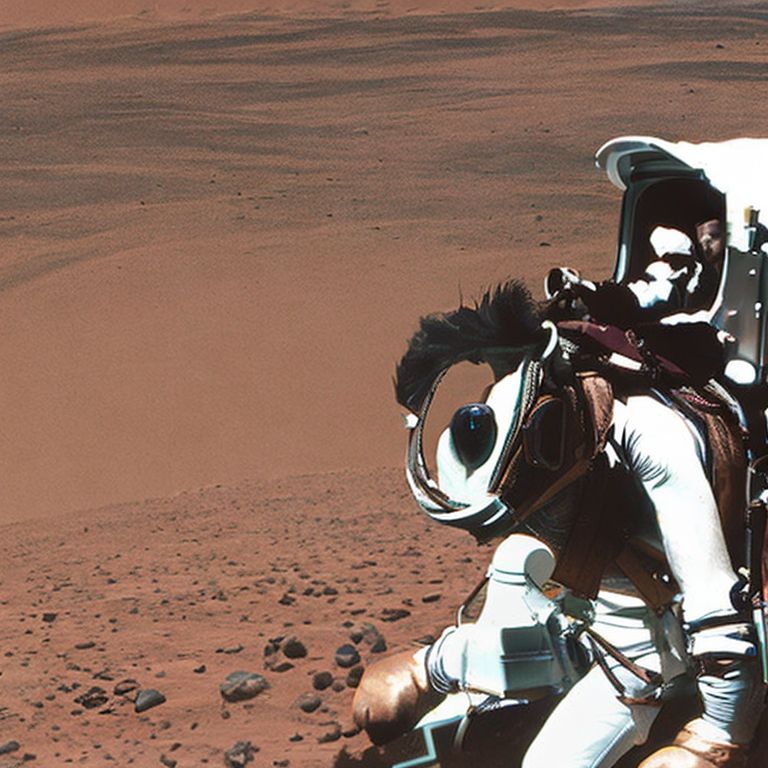

In [8]:
images[1]